In [454]:
import pandas as pd
import numpy as np
import plotly.express as px
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import proportions_chisquare
from scipy.stats import shapiro
from scipy.stats import ttest_ind
from scipy.stats import norm, t
from statsmodels.stats import proportion

### Анализ структуры данных

In [455]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


In [456]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


Формат столбца с датой нужно перевести в datetime.

In [457]:
data.date = pd.to_datetime(data.date)

Проверяем одинаковой длительности проведения A/B-тестирования в каждой из групп.

In [458]:
date_min = data.groupby('group')['date'].min()
date_max = data.groupby('group')['date'].max()
print(date_min, date_max)

group
A   2021-01-02
B   2021-01-02
Name: date, dtype: datetime64[ns] group
A   2021-01-24
B   2021-01-24
Name: date, dtype: datetime64[ns]


По интервалу совпадает, теперь проверим по количеству дней.

In [459]:
print(f"Количество дней наблюдений в группе А: {data[data.group=='A'].date.unique().shape[0]}")
print(f"Количество дней наблюдений в группе B: {data[data.group=='B'].date.unique().shape[0]}")

Количество дней наблюдений в группе А: 23
Количество дней наблюдений в группе B: 23


Длительность проведения тестирования одинакова в обеих группах.

In [460]:
data.isnull().sum()

user_id     0
date        0
group       0
purchase    0
price       0
dtype: int64

In [461]:
data.user_id.unique()

array([851104, 804228, 661590, ..., 734608, 697314, 715931], dtype=int64)

In [462]:
data.date.unique()

<DatetimeArray>
['2021-01-21 00:00:00', '2021-01-12 00:00:00', '2021-01-11 00:00:00',
 '2021-01-08 00:00:00', '2021-01-10 00:00:00', '2021-01-19 00:00:00',
 '2021-01-17 00:00:00', '2021-01-04 00:00:00', '2021-01-15 00:00:00',
 '2021-01-18 00:00:00', '2021-01-09 00:00:00', '2021-01-22 00:00:00',
 '2021-01-24 00:00:00', '2021-01-23 00:00:00', '2021-01-20 00:00:00',
 '2021-01-05 00:00:00', '2021-01-06 00:00:00', '2021-01-13 00:00:00',
 '2021-01-07 00:00:00', '2021-01-03 00:00:00', '2021-01-02 00:00:00',
 '2021-01-16 00:00:00', '2021-01-14 00:00:00']
Length: 23, dtype: datetime64[ns]

In [463]:
data.group.unique()

array(['A', 'B'], dtype=object)

In [464]:
data.purchase.unique()

array([0, 1], dtype=int64)

In [465]:
data.price.unique()

array([     0, 150000,  10000,  60000, 100000, 200000], dtype=int64)

Явных пропусков нет, скрытых тоже.

In [466]:
data_group = data.groupby('user_id')['group'].nunique()

Нашлись 1895 пользователей, попавших в обе группы. Удалим их.

In [467]:
list_delete = list(data_group[data_group==2].index)
data.drop(data.loc[data.user_id.isin(list_delete)].index, inplace=True)

### Первичный анализ результатов A/B-тестирования

Количество посещений сайта

In [468]:
print(f"Количество посещений в группе А: {data[data.group=='A']['user_id'].count()}")
print(f"Количество посещений в группе В: {data[data.group=='B']['user_id'].count()}")

Количество посещений в группе А: 145307
Количество посещений в группе В: 145381


Суммарное количество совершённых покупок

In [469]:
print(f"Количество покупок в группе А: {data[data.group=='A']['purchase'].sum()}")
print(f"Количество покупок в группе B: {data[data.group=='B']['purchase'].sum()}")

Количество покупок в группе А: 17487
Количество покупок в группе B: 17290


Cумма всех покупок

In [470]:
print(f"Сумма всех покупок в группе А: {data[data.group=='A']['price'].sum()}")
print(f"Сумма всех покупок в группе B: {data[data.group=='B']['price'].sum()}")

Сумма всех покупок в группе А: 1417780000
Сумма всех покупок в группе B: 1533010000


Все показатели примерно одинаковы, считаю что выборка сбалансирована.

In [471]:
print(f"Конверсия в группе А: {data[data.group=='A']['purchase'].mean().round(3)}")
print(f"Конверсия в группе B: {data[data.group=='B']['purchase'].mean().round(3)}")

Конверсия в группе А: 0.12
Конверсия в группе B: 0.119


In [472]:
print(f"Средний чек в группе А: {data[data.group=='A']['price'].mean().round(3)}")
print(f"Средний чек в группе B: {data[data.group=='B']['price'].mean().round(3)}")

Средний чек в группе А: 9757.135
Средний чек в группе B: 10544.775


По конверсии разницы практически нет, а по среднему чеку она совсем незначительная, но в группе B средний чек немного выше.

In [473]:
data_piv = pd.pivot_table(data,
                          index='price',
                          columns='group' ,
                          values='user_id',
                          aggfunc='count',
).reset_index(drop=True).set_index([pd.Index(['Нет',
                                              'Санкт-Петербург',
                                              'Турция','Таиланд',
                                              'Камчатка','Мальдивы'])]
                                   )
data_piv

group,A,B
Нет,127820,128091
Санкт-Петербург,5182,5201
Турция,5271,1730
Таиланд,1832,5227
Камчатка,3478,3438
Мальдивы,1724,1694


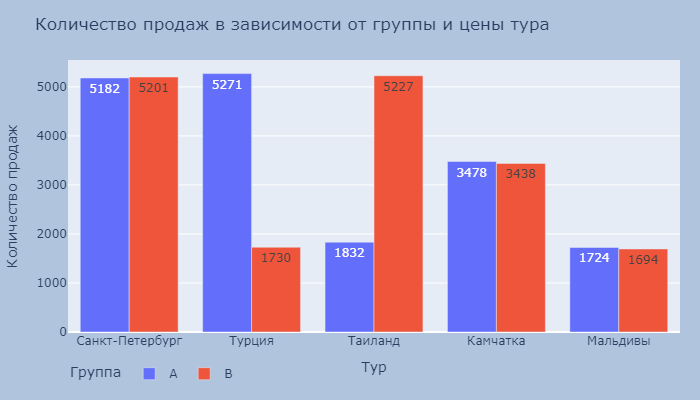

In [474]:
fig = px.bar(data_piv.drop('Нет', axis=0),
             barmode='group',
             height=400,
             width=700,
             text_auto=True,
             title='Количество продаж в зависимости от группы и цены тура',
             labels={'index':'Тур',
                     'value':'Количество продаж',
                     'group':'Группа'}
)

fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue',
    legend = dict(orientation='h')
)
fig.show('png')

В трех турах количество продаж почти одинаково. Туры в Турцию чаще покупали пользователи из групы А, а в турах в Таиланд противоположная ситуация - их чаще покупают пользователи из группы В. Можно предположить что туры в Таиланд на новом дизайне представлены в более выгодном свете, несмотря на их цену(больше чем в Турции).

### Анализ данных на предмет стабилизации метрик

In [475]:
daily_data = data.groupby(['date', 'group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id': 'user_count'})
daily_data.head()

,date,group,user_count,purchase,price
0,2021-01-02,A,2854,359,29410000
1,2021-01-02,B,2861,345,29660000
2,2021-01-03,A,6596,748,62000000
3,2021-01-03,B,6619,754,65960000
4,2021-01-04,A,6566,799,64250000


In [490]:
daily_data_a = daily_data[daily_data['group'] == 'A']
daily_data_b = daily_data[daily_data['group'] == 'B']

daily_data_a.loc[:, 'conversion'] = daily_data_a.purchase/daily_data_a.user_count*100
daily_data_a.loc[:, 'cheque'] = daily_data_a.price/daily_data_a.purchase
daily_data_a.loc[:, 'cum_user_count'] = daily_data_a.user_count.cumsum()
daily_data_a.loc[:, 'cum_purchase'] = daily_data_a.purchase.cumsum()
daily_data_a.loc[:, 'cum_price'] = daily_data_a.price.cumsum()
daily_data_a.loc[:, 'cum_conversion'] = daily_data_a.cum_purchase/daily_data_a.cum_user_count*100
daily_data_a.loc[:, 'cum_cheque'] = daily_data_a.cum_price/daily_data_a.cum_purchase*100

daily_data_b.loc[:, 'conversion'] = daily_data_b.purchase/daily_data_b.user_count*100
daily_data_b.loc[:, 'cheque'] = daily_data_b.price/daily_data_b.purchase
daily_data_b.loc[:, 'cum_user_count'] = daily_data_b.user_count.cumsum()
daily_data_b.loc[:, 'cum_purchase'] = daily_data_b.purchase.cumsum()
daily_data_b.loc[:, 'cum_price'] = daily_data_b.price.cumsum()
daily_data_b.loc[:, 'cum_conversion'] = daily_data_b.cum_purchase/daily_data_b.cum_user_count*100
daily_data_b.loc[:, 'cum_cheque'] = daily_data_b.cum_price/daily_data_b.cum_purchase*100

daily_data = pd.concat([daily_data_a, daily_data_b])

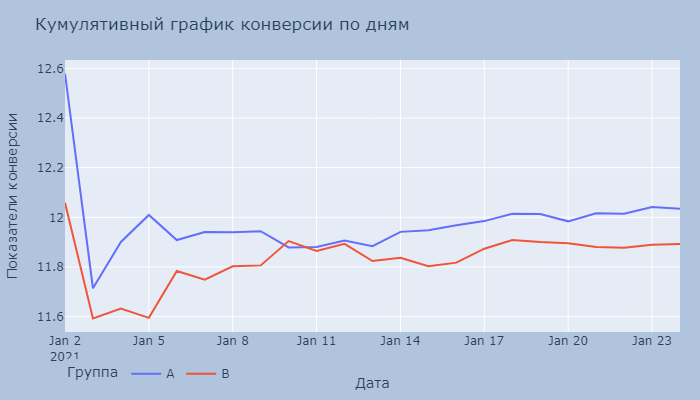

In [477]:
fig = px.line(daily_data, x='date', y='cum_conversion',
              color='group',
              height=400,
              width=700,
              title='Кумулятивный график конверсии по дням',
              labels={'date':'Дата',
                      'cum_conversion':'Показатели конверсии',
                      'group':'Группа'}
)

fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue',
    legend = dict(orientation='h')
)
fig.show('png')

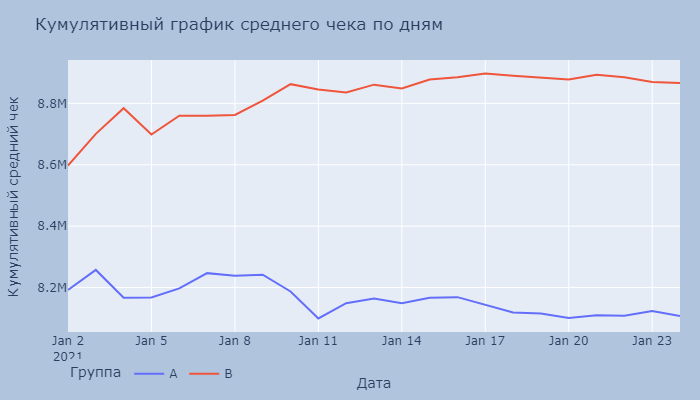

In [478]:
fig = px.line(daily_data, x='date', y='cum_cheque',
              color='group',
              height=400,
              width=700,
              title='Кумулятивный график среднего чека по дням',
              labels={'date':'Дата',
                      'cum_cheque':'Кумулятивный средний чек',
                      'group':'Группа'}
)

fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue',
    legend = dict(orientation='h')
)
fig.show('png')

Кумулятивные графики стабилизировались, поэтому можно считать длительность эксперимента достаточной для того, чтобы судить о статистической значимости разности между показателем конверсии в группах.

Есть небольшая разница в конверсиях. Также наблюдается значительная разница в среднем чеке наблюдений.

### Статистический анализ результатов A/B-тестирования

In [479]:
# функция для красивого вывода решения
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if (p <= alpha):
        print("Отвергаем нулевую гипотезу в пользу альтернативной")
    else:
        print("У нас нет оснований отвергнуть нулевую гипотезу")
        
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))

**Есть ли статистическая разница между конверсиями в группах А и B?**

Группы независимы, будем использовать Z-тест для пропорций.

*Нулевая гипотеза* ($H_0$): конверсии в группах A и B равны..

$$ H_0 : p_a = p_b$$

*Альтернативная гипотеза* ($H_1$):  конверсии в группах A и B не равны..

$$ H_1 : p_a \neq p_b$$

In [480]:
data_temp = data.groupby('group')['purchase'].agg(['sum', 'count'])

In [481]:
alpha = 0.05

_, p_value = proportions_ztest(
    count=data_temp['sum'],
    nobs=data_temp['count'],
    alternative='two-sided'
)
decision_hypothesis(p_value)

p-value = 0.239
У нас нет оснований отвергнуть нулевую гипотезу


Принимаем нулевую гипотезу о равенстве конверсий. По результатам теста статистической разницы между конверсиями в двух группах нет.

**Есть ли статистическая разница между ежедневными средними чеками в группах А и B?**

*Нулевая гипотеза* ($H_0$): средний чек пользователя из группы А равен среднему чеку пользователя из группы B.

$$ H_0 : p_a = p_b$$

*Альтернативная гипотеза* ($H_1$): средний чек пользователя из группы А отличается от среднего чека пользователя из группы B.

$$ H_1 : p_a \neq p_b$$

In [482]:
_, p_value = shapiro(daily_data[daily_data.group=='A'].cheque)
decision_normality(p_value)

_, p_value = shapiro(daily_data[daily_data.group=='B'].cheque)
decision_normality(p_value)

p-value = 0.253
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
p-value = 0.094
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


Распределение нормальное в обеих группах, значит выбираем двухвыборочный T-тест.

In [483]:
alpha = 0.05

results = ttest_ind(
    a=daily_data[daily_data.group=='A'].cheque,
    b=daily_data[daily_data.group=='B'].cheque,
    alternative='two-sided'
)
decision_hypothesis(results.pvalue)

p-value = 0.000
Отвергаем нулевую гипотезу в пользу альтернативной


Принимаем альтернативную гипотезу. По результатам теста между средними чеками в двух группах есть статистическая разница. Посмотрим в какую сторону.

*Нулевая гипотеза* ($H_0$): средний чек пользователя из группы А больше или равен среднему чеку пользователя из группы B.

$$ H_0 : p_a >= p_b$$

*Альтернативная гипотеза* ($H_1$): средний чек пользователя из группы А меньше среднего чека пользователя из группы B.

$$ H_1 : p_a < p_b$$

In [484]:
alpha = 0.05

results = ttest_ind(
    a=daily_data[daily_data.group=='A'].cheque,
    b=daily_data[daily_data.group=='B'].cheque,
    alternative='less'
)
decision_hypothesis(results.pvalue)

p-value = 0.000
Отвергаем нулевую гипотезу в пользу альтернативной


Ежедневный средний чек пользователей из группы А меньше ежедневного среднего чека пользователей из группы В, разница статистически значима. Думаю это могло произойти из-за разницы Турция-Таиланд, потому что разница в цене данных туров велика.

#### конверсия в каждой из групп

In [485]:
data_a = data[data.group=='A']
data_b = data[data.group=='B']

In [486]:
lower_bound_a, upper_bound_a = proportion.proportion_confint(
    count=data_a.purchase.sum(),
    nobs=data_a.user_id.count(),
    alpha=0.05
)

lower_bound_b, upper_bound_b = proportion.proportion_confint(
    count=data_b.purchase.sum(),
    nobs=data_b.user_id.count(),
    alpha=0.05
)

print('Доверительный интервал для конверсии в группе А: {}'.format((round(lower_bound_a * 100, 2), round(upper_bound_a * 100, 2))))
print('Доверительный интервал для конверсии в группе B: {}'.format((round(lower_bound_b * 100, 2), round(upper_bound_b * 100, 2))))

Доверительный интервал для конверсии в группе А: (11.87, 12.2)
Доверительный интервал для конверсии в группе B: (11.73, 12.06)


С надёжностью в 95 % конверсия группы А лежит в интервале от 11.87 % до 12.2 %, а конверсия группы B лежит в интервале от 11.73 % до 12.06 %.

Присутствует перекрытие между доверительными интервалами для групп, поэтому стоит построить доверительный интервал разницы конверсий.

#### разница конверсий

In [487]:
n = [data_a.user_id.count(), data_b.user_id.count()]
x_p = [data_a.purchase.mean(), data_b.purchase.mean()]

alpha = 0.05
diff = data_b.purchase.mean() - data_a.purchase.mean()
z_crit = -norm.ppf(alpha/2)
eps = z_crit * (x_p[0] * (1 - x_p[0])/n[0] + x_p[1] * (1 - x_p[1])/n[1]) ** 0.5
lower_bound = (diff - eps).round(4)*100
upper_bound = (diff + eps).round(4)*100
print('Доверительный интервал для разности конверсий: {}'.format((lower_bound, upper_bound)))

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Интервал охватывает точку 0, значит варианты А и В равнозначны по метрике конверсий.

#### ежедневный средний чек в каждой из групп

In [488]:
gamma = 0.95
n = 23
k = n-1
x_mean = daily_data_a.cheque.mean()
x_std = np.std(daily_data_a.cheque)
lower, upper = t.interval(gamma, df=k, loc=x_mean, scale=x_std/(n ** 0.5))
print('Доверительный интервал среднего чека в группе А: {}'.format((round(lower), round(upper))))

Доверительный интервал среднего чека в группе А: (79660, 82279)


In [489]:
gamma = 0.95
n = daily_data_b.shape[0]
k = n-1
x_mean = daily_data_b.cheque.mean()
x_std = np.std(daily_data_b.cheque)
lower, upper = t.interval(gamma, df=k, loc=x_mean, scale=x_std/(n ** 0.5))
print('Доверительный интервал среднего чека в группе В: {}'.format((round(lower), round(upper))))

Доверительный интервал среднего чека в группе В: (87647, 89505)


С надежностью 95% истинные траты пользователей из группы А лежат в интервале от 79 660 до 82 279 рублей, а пользователей группы В - от 87 647 до 89 505.

### Общий вывод по результатам A/B-теста

Принимая во внимание графики кумулятивных конверсий, результаты статистического теста для конверсий, а также расчеты доверительных интервалов и разницы этих интервалов, мы не можем дать точный ответ какой вариант посадочной страницы является предпочтительным.

Ответ на этот вопрос нам помогли найти кумулятивный график среднего чека, результаты статистических тестов ежедневных средних чеков и их доверительные интервалы в каждой из групп - вариант В является более эффективным.